In [1]:
from models import *

In [4]:
generator = GenerativeNetwork()
generator.load_state_dict(torch.load('./checkpoints/generator_12-02-2023_15-11-41_def.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
with open('./data/1000.mus','rb') as fd:
    data = pickle.load(fd)
stft = librosa.stft(np.asarray(data), n_fft=4096, win_length=4096, window=signal.windows.hamming(4096))
spectrogram = librosa.amplitude_to_db(abs(stft))

phase = np.angle(stft)
MIN = spectrogram.min()
MAX = spectrogram.max()
spectrogram = (spectrogram-spectrogram.min())/(spectrogram.max()-spectrogram.min())



lb = spectrogram[1:1025,:1024]
hb = spectrogram[1025:,:1024]

lb = torch.tensor(lb.reshape(1,1,1024,1024))
hb = torch.tensor(hb.reshape(1,1,1024,1024))

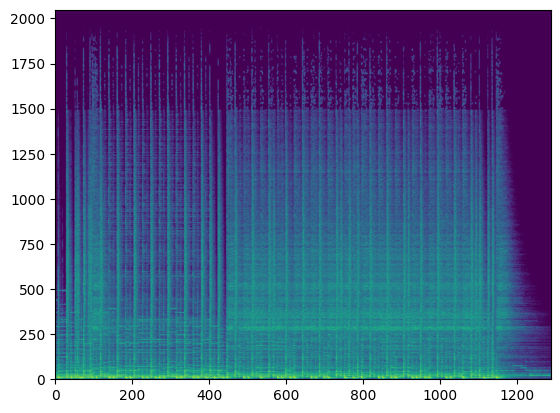

In [21]:
plt.imshow(spectrogram,origin='lower',aspect='auto')

In [18]:
generated_hb = generator(lb)

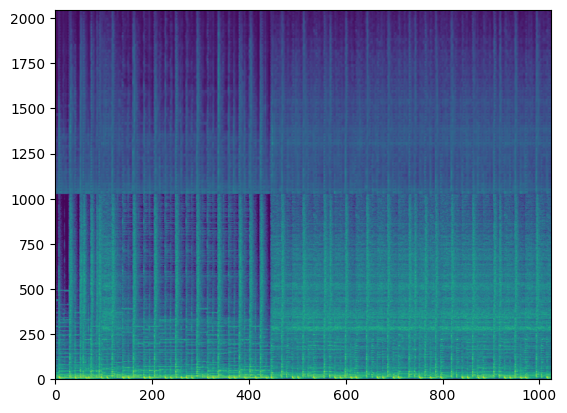

In [19]:
generated = torch.cat((lb, generated_hb), dim=2)
generated = generated.cpu().detach().numpy().reshape(-1,1024)
generated.shape
plt.imshow(generated, origin='lower', aspect='auto')

In [23]:
generated = torch.cat((lb, generated_hb[:,:,:,:]), dim=2)
generated = generated.cpu().detach().numpy().reshape(-1,1024)
generated = generated * (MAX-MIN) + MIN
generated = librosa.db_to_amplitude(generated)
generated = generated * np.exp(1j*phase[1:,:1024])
generated = librosa.istft(generated, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)
import soundfile as sf
sf.write('./out/generated.wav', generated, 44000)


original = spectrogram[:,:1024]
original = original * (MAX-MIN) + MIN
original = librosa.db_to_amplitude(original)
original = original * np.exp(1j*phase[:,:1024])
original = librosa.istft(original, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)
sf.write('./out/original.wav', original, 44000)


low_res = lb.cpu().detach().numpy().reshape(1024,1024)
low_res = low_res * (MAX-MIN) + MIN
low_res = librosa.db_to_amplitude(low_res)
low_res = low_res * np.exp(1j*phase[1:1025,:1024])
low_res = librosa.istft(low_res, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)
sf.write('./out/low_res.wav', low_res, 44000)